## Alpha-Beta Divergence For Variational Inference
Alpha Beta comparison with other methods for  Boston Housing Dataset

In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch

from objectives import KL, Renyi, AB, det_loss
from models import VI

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

### Data

In [2]:
x, y = load_boston(return_X_y=True)
y_ = y.copy()

scaler = StandardScaler()
x_ = scaler.fit_transform(x)

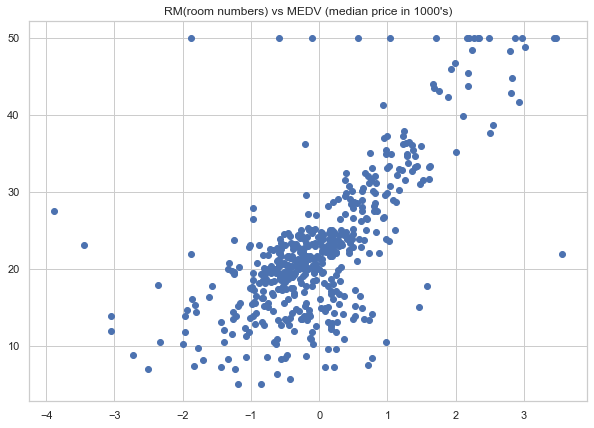

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[10,7])
axs.scatter(x_[:,5], y)
axs.set_title('RM(room numbers) vs MEDV (median price in 1000\'s)')
plt.show()

### Data preparation

In [4]:
# Train test split of the data
y_ = y_.reshape((len(y_),1))
X_train, X_val, y_train, y_val = train_test_split(x_, y_, test_size=0.2)

In [5]:
# Tensor format of our dataset
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)

X_val = torch.tensor(X_val, dtype=torch.float)
y_val = torch.tensor(y_val, dtype=torch.float)


In [6]:
Xtrain_loader = DataLoader(X_train, batch_size=50)
ytrain_loader = DataLoader(y_train, batch_size=50)

Xval_loader = DataLoader(X_val, batch_size=50)
yval_loader = DataLoader(y_val, batch_size=50)

### Training

In [22]:
def train(model, optimizer, criterion, epochs=3000):
    train_losses = []
    validation_losses = []

    for epoch in range(epochs):

        model.train()
        for x, y in zip(Xtrain_loader, ytrain_loader):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_pred, mu, log_var = model(x)
            loss = -criterion.compute_bound(y_pred, y)
            loss.backward()
            optimizer.step()

            # save loss
            train_losses.append(loss.item())

        model.eval()
        for x, y in zip(Xval_loader, yval_loader):
            y_pred, mu, log_var = model(x)
            loss = -criterion.compute_bound(y_pred, y)

            # save loss
            validation_losses.append(loss.item())

        if epoch%500==0:
            #print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_losses[-1], validation_losses[-1]))
            print(criterion.qm.data.numpy(), (criterion.softplus(criterion.qs).data**2).numpy())

**Elbo**

In [30]:
# ELBO 
epochs = 5000
m = VI(13, 10, 1)
optimizer = torch.optim.Adam(m.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()


train_losses = []
validation_losses = []

for epoch in range(epochs):
    
    m.train()
    for x, y in zip(Xtrain_loader, ytrain_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred, mu, log_var = m(x)
        #loss = criterion(y_pred, y)
        loss = det_loss(y_pred, y, mu, log_var)
        loss.backward()
        optimizer.step()

        # save loss
        train_losses.append(loss.item())
    
    m.eval()
    for x, y in zip(Xval_loader, yval_loader):
        y_pred, mu, log_var = m(x)
        loss = criterion(y_pred, y)

        # save loss
        validation_losses.append(loss.item())
        
    if epoch%500==0:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_losses[-1], validation_losses[-1]))

Epoch 00/5000 || Loss:  Train 148.9778 | Validation 372.8938
Epoch 500/5000 || Loss:  Train 15.1957 | Validation 351.5512
Epoch 1000/5000 || Loss:  Train 32.1032 | Validation 315.6571
Epoch 1500/5000 || Loss:  Train 16.8663 | Validation 370.7560
Epoch 2000/5000 || Loss:  Train 22.3692 | Validation 126.8648
Epoch 2500/5000 || Loss:  Train 31.8946 | Validation 193.0427
Epoch 3000/5000 || Loss:  Train 14.4501 | Validation 436.1842
Epoch 3500/5000 || Loss:  Train 32.1215 | Validation 425.3961
Epoch 4000/5000 || Loss:  Train 12.0154 | Validation 184.6882
Epoch 4500/5000 || Loss:  Train 40.0478 | Validation 656.7278


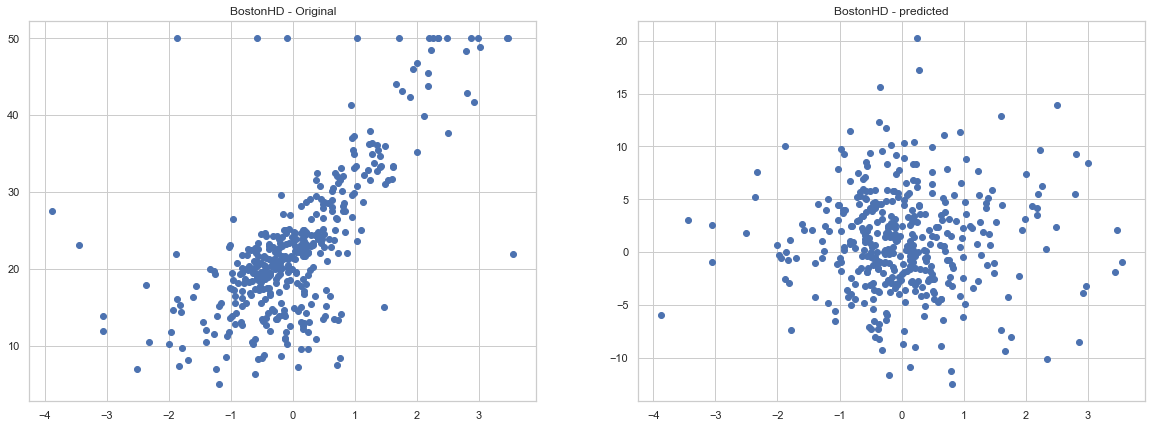

In [31]:
m.eval()
y_pred, _, _ = m(X_train)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[20,7])
axs[0].scatter(X_train[:,5], y_train)
axs[1].scatter(X_train[:,5], y_pred.detach().cpu())
axs[0].set_title('BostonHD - Original')
axs[1].set_title('BostonHD - predicted')
plt.show()

**Kl divergence**

In [24]:
# KL Divergence
epochs = 1000
m = VI(13, 10, 1)
optimizer = torch.optim.Adam(m.parameters(), lr=0.01)
criterion = KL()


train_losses = []
validation_losses = []

train(m, optimizer, criterion, epochs)

[[1.19510591]] [[0.15373028]]
[[1.19510591]] [[0.15373028]]


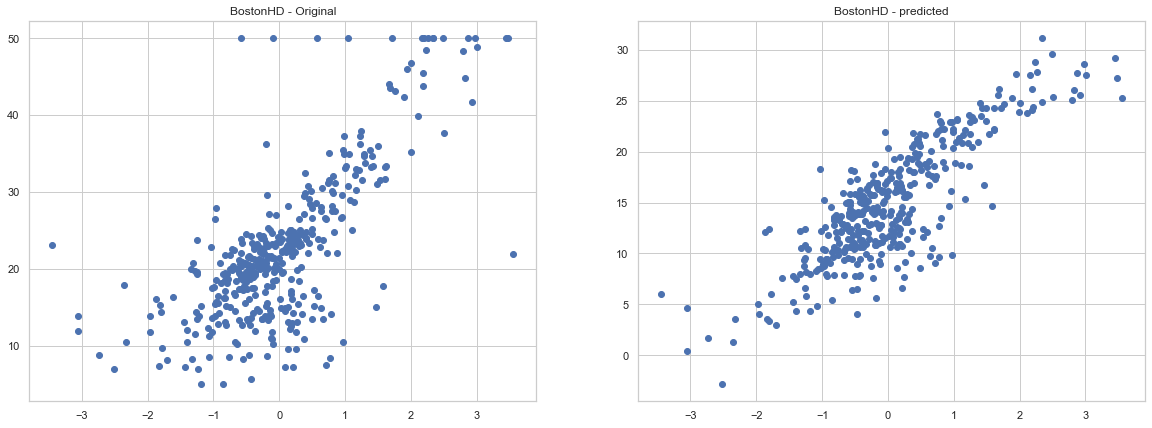

In [25]:
with torch.no_grad():
    y_pred, _, _ = m(X_train)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[20,7])
axs[0].scatter(X_train[:,5], y_train)
axs[1].scatter(X_train[:,5], y_pred.detach().cpu())
axs[0].set_title('BostonHD - Original')
axs[1].set_title('BostonHD - predicted')
plt.show()

**Renyi divergence**

In [15]:
# Renyi Divergence
epochs = 4000
m = VI(13, 10, 1)
optimizer = torch.optim.Adam(m.parameters(), lr=0.005)
criterion = Renyi(alpha=0.5, latent_dim=13)

train(m, optimizer, criterion, epochs)

[[-1.25819182]] [[0.24964219]]
[[-1.25819182]] [[0.24964219]]
[[-1.25819182]] [[0.24964219]]
[[-1.25819182]] [[0.24964219]]
[[-1.25819182]] [[0.24964219]]
[[-1.25819182]] [[0.24964219]]
[[-1.25819182]] [[0.24964219]]
[[-1.25819182]] [[0.24964219]]


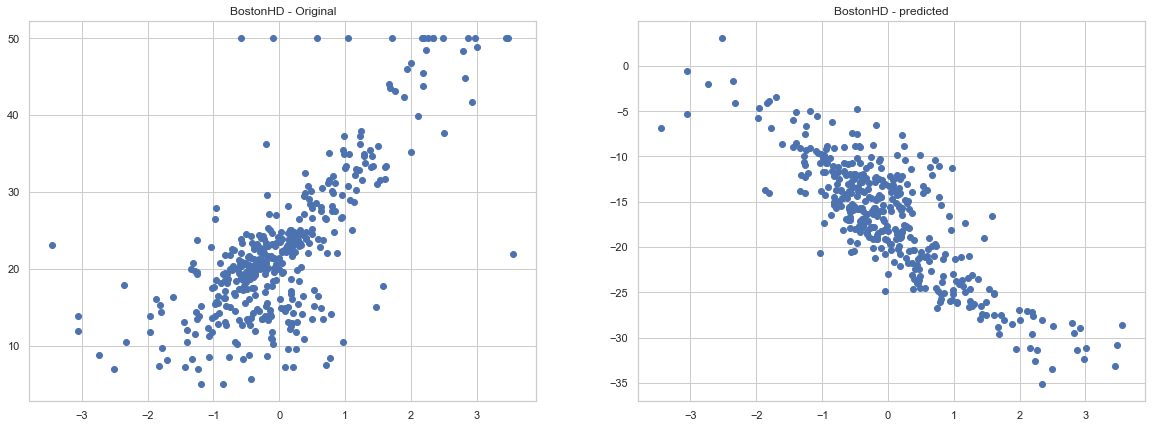

In [16]:
m.eval()
y_pred, _, _ = m(X_train)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[20,7])
axs[0].scatter(X_train[:,5], y_train)
axs[1].scatter(X_train[:,5], y_pred.detach().cpu())
axs[0].set_title('BostonHD - Original')
axs[1].set_title('BostonHD - predicted')
plt.show()

**AB divergence**

In [19]:
# Renyi Divergence
epochs = 5000
m = VI(13, 10, 1)
optimizer = torch.optim.Adam(m.parameters(), lr=0.01)
criterion = AB(alpha = 1.25, beta = -0.25, latent_dim=13)

train(m, optimizer, criterion, epochs)

[[0.19479617]] [[0.149923]]
[[0.19479617]] [[0.149923]]
[[0.19479617]] [[0.149923]]
[[0.19479617]] [[0.149923]]
[[0.19479617]] [[0.149923]]
[[0.19479617]] [[0.149923]]
[[0.19479617]] [[0.149923]]
[[0.19479617]] [[0.149923]]
[[0.19479617]] [[0.149923]]
[[0.19479617]] [[0.149923]]


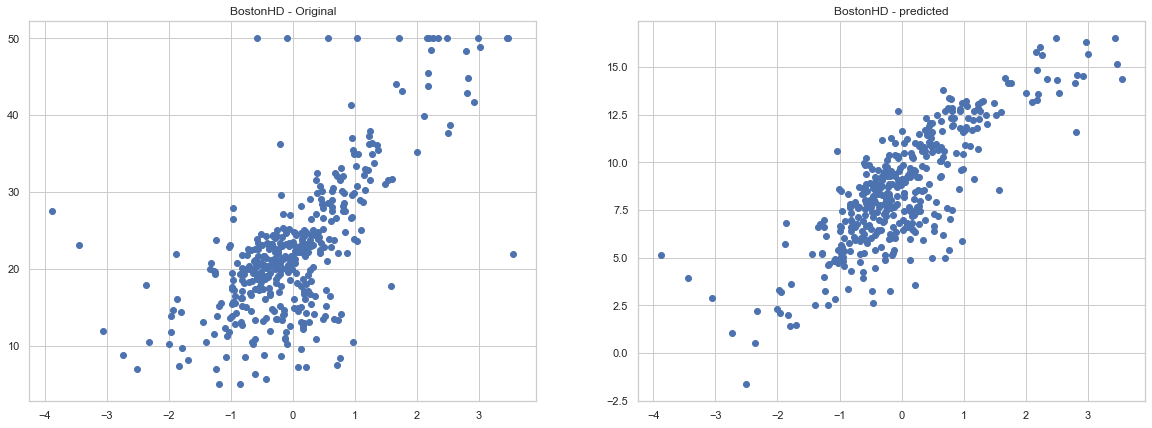

In [18]:
m.eval()
y_pred, _, _ = m(X_train)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[20,7])
axs[0].scatter(X_train[:,5], y_train)
axs[1].scatter(X_train[:,5], y_pred.detach().cpu())
axs[0].set_title('BostonHD - Original')
axs[1].set_title('BostonHD - predicted')
plt.show()